*Ce billet a été écrit à l'aide d'un notebook Jupyter. Son contenu est sous licence BSD. Une vue statique de ce notebook peut être consultée et téléchargée ici : [20170614_Legislatives.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170614_Legislatives.ipynb).*

Dans ce billet, nous allons nous intéresser aux résultats du premier tour des législatives 2017. Ce billet fait suite à mes billets précédents sur les élections présidentielles ([premier tour](http://flothesof.github.io/cartes-premier-tour-presidentielle-2017.html), [deuxième tour](http://flothesof.github.io/cartes-second-tour-presidentielle-2017.html)) et utilise les mêmes techniques pour aspirer le site du ministère de l'intérieur et en faire des graphiques.

Les résultats officiels sont disponibles ici : <http://elections.interieur.gouv.fr/legislatives-2017>.

# Obtenir les données 

In [37]:
# import des packages 
from bs4 import BeautifulSoup
import requests
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
from collections import OrderedDict
from scipy import stats
import numpy as np

Tout d'abord, allons aspirer le site officiel du ministère de l'intérieur.

In [2]:
url = 'http://elections.interieur.gouv.fr/legislatives-2017/'

In [3]:
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

Les résultats sont organisés par circonscription. Trouvons les liens vers toutes les pages relatives aux circonscriptions.

In [4]:
links = [url + tag.attrs['href'][2:] for tag in soup.find_all('a', class_='Style6')]

In [5]:
from functools import lru_cache

@lru_cache(maxsize=1024)
def fetch_page(url):
    "Fetches url for webpage."
    r = requests.get(url)
    return r

In [6]:
circo_links = []
for link in links:
    soup = BeautifulSoup(fetch_page(link).text, 'html.parser')
    circo_links += [url + tag.attrs['href'][3:] for tag in soup.find_all('a') if 'circonscription' in tag.text.lower()]

On vérifie qu'on a le bon nombre de circonscriptions.

In [7]:
len(circo_links)

577

Maintenant, nous allons pouvoir extraire les tableaux qui figurent sur les différentes pages.

In [8]:
circo_links[0]

'http://elections.interieur.gouv.fr/legislatives-2017/001/00101.html'

In [9]:
r = fetch_page(circo_links[0])

In [10]:
soup = BeautifulSoup(r.text, 'html.parser')

On peut trouver le titre de la circonscription assez facilement :

In [11]:
soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]

'Ain (01) - 1ère'

On peut récuperer une première table sur les stats liés à la circonscription.

In [12]:
table = soup.find_all('tbody')[1]
votes = OrderedDict()
for row in table.find_all('tr'):
    votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))

In [13]:
pd.Series(votes).to_frame()

,0
Inscrits,82694
Abstentions,42063
Votants,40631
Blancs,545
Nuls,155
Exprimés,39931


Ainsi que les résultats par candidats.

In [14]:
table = soup.find_all('tbody')[0]
candidates = OrderedDict()
for row in table.find_all('tr'):
    candidates[row.td.text] = []
    for td in row.find_all('td')[1:]:
        stripped = td.text.strip().replace(',', '.').replace(' ', '')
        candidates[row.td.text].append(stripped)

In [15]:
pd.DataFrame(candidates).transpose()

,0,1,2,3,4
M. Laurent MALLET,MDM,13534,16.37,33.89,Ballotage*
M. Xavier BRETON,LR,10693,12.93,26.78,Ballotage*
M. Jérôme BUISSON,FN,6174,7.47,15.46,Non
Mme Fabrine MARTIN ZEMLIK,FI,3874,4.68,9.70,Non
Mme Florence BLATRIX-CONTAT,SOC,3687,4.46,9.23,Non
M. Jacques FONTAINE,COM,656,0.79,1.64,Non
Mme Laurane RAIMONDO,ECO,562,0.68,1.41,Non
Mme Maude LÉPAGNOT,EXG,293,0.35,0.73,Non
Mme Marie CARLIER,DIV,247,0.30,0.62,Non
M. Gilbert BONNOT,DIV,211,0.26,0.53,Non


On peut maintenant écrire une fonction qui rassemble ces extractions.

In [16]:
def extract_circo_data(url):
    "Returns data for circo: name, candidates, votes."
    r = fetch_page(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    circo_name = soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]
    table = soup.find_all('tbody')[0]
    candidates = OrderedDict()
    for row in table.find_all('tr'):
        candidates[row.td.text] = []
        for td in row.find_all('td')[1:]:
            stripped = td.text.strip().replace(',', '.').replace(' ', '')
            candidates[row.td.text].append(stripped)
    table = soup.find_all('tbody')[1]
    votes = OrderedDict()
    for row in table.find_all('tr'):
        votes[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
    votes = pd.Series(votes).to_frame()
    votes.columns = [circo_name]
    return circo_name, pd.DataFrame(candidates).transpose(), votes

In [17]:
circo_name, candidates, votes = extract_circo_data(circo_links[0])

Maintenant passons aux graphiques.

# Votants par circonscription 

In [18]:
%%time
all_votes_data = [extract_circo_data(url)[2] for url in circo_links]
all_votes = pd.concat(all_votes_data, axis=1)

Wall time: 1min 11s


In [19]:
all_votes

,Ain (01) - 1ère,Ain (01) - 2ème,Ain (01) - 3ème,Ain (01) - 4ème,Ain (01) - 5ème,Aisne (02) - 1ère,Aisne (02) - 2ème,Aisne (02) - 3ème,Aisne (02) - 4ème,Aisne (02) - 5ème,...,Français établis hors de France (99) - 2ème,Français établis hors de France (99) - 3ème,Français établis hors de France (99) - 4ème,Français établis hors de France (99) - 5ème,Français établis hors de France (99) - 6ème,Français établis hors de France (99) - 7ème,Français établis hors de France (99) - 8ème,Français établis hors de France (99) - 9ème,Français établis hors de France (99) - 10ème,Français établis hors de France (99) - 11ème
Inscrits,82694,93520,75614,89390,75359,72345,73981,68099,79116,82223,...,75029,120696,122765,91374,127486,105955,121399,107796,99374,92766
Abstentions,42063,47291,41131,45625,38409,36770,39857,35369,43878,41864,...,63414,95202,94943,76810,101742,78999,109986,92085,79955,67141
Votants,40631,46229,34483,43765,36950,35575,34124,32730,35238,40359,...,11615,25494,27822,14564,25744,26956,11413,15711,19419,25625
Blancs,545,471,359,521,374,517,685,639,530,609,...,36,43,68,71,47,50,41,140,175,93
Nuls,155,160,116,211,168,173,270,287,208,251,...,79,81,90,48,92,332,72,122,79,152
Exprimés,39931,45598,34008,43033,36408,34885,33169,31804,34500,39499,...,11500,25370,27664,14445,25605,26574,11300,15449,19165,25380


Commençons par agréger les résultats en les sommant.

In [20]:
all_votes.sum(axis=1).to_frame(name='France entière')

,France entière
Inscrits,47570988
Abstentions,24403480
Votants,23167508
Blancs,357018
Nuls,156326
Exprimés,22654164


On peut représenter ceci sous forme d'un graphique.

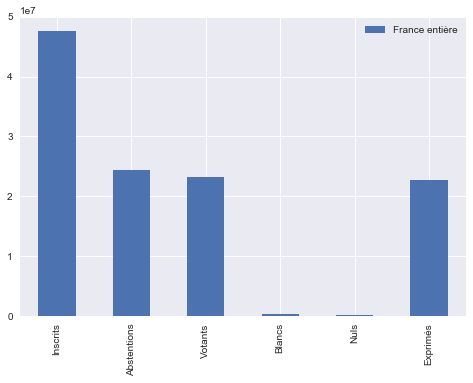

In [21]:
all_votes.sum(axis=1).to_frame(name='France entière').plot.bar()

Comme cela a été signalé dans la presse, il y a eu plus d'abstentions que de votants. On remarque qu'il y a beaucoup moins de blancs et de nuls que lors de la présidentielle (2,5 millions de blancs au deuxième tour de la présidentielle). 10 millions de Français de plus se sont abstenus d'aller voter qu'au deuxième tour de la présidentielle. 

Regardons maintenant quel graphique nous obtenons si nous faisons un graphique pour toutes les circonscriptions.

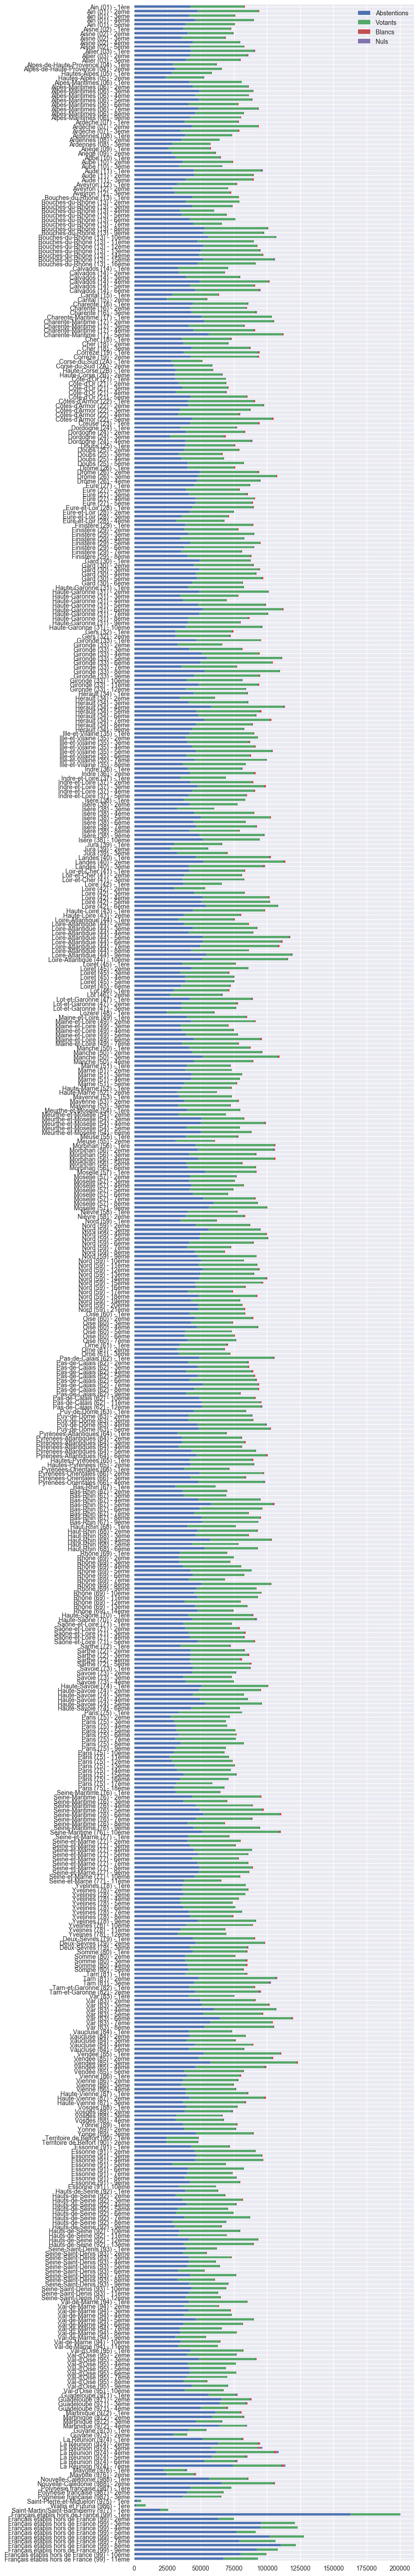

In [22]:
fig, ax = plt.subplots(figsize=(8, 75), dpi=100)
all_votes.transpose()[['Abstentions', 'Votants', 'Blancs', 'Nuls']].iloc[::-1].plot.barh(stacked=True, ax=ax)

Une autre manière de représenter ces données peut être l'utilisation d'un scatter plot. Nous allons faire ceci avec `seaborn`. La fonction `pairplot` nous permet de dessiner les corrélations entre les variables deux à deux. Voyons-voir si certaines de ces corrélations attirent notre attention. 

In [23]:
import seaborn as sns

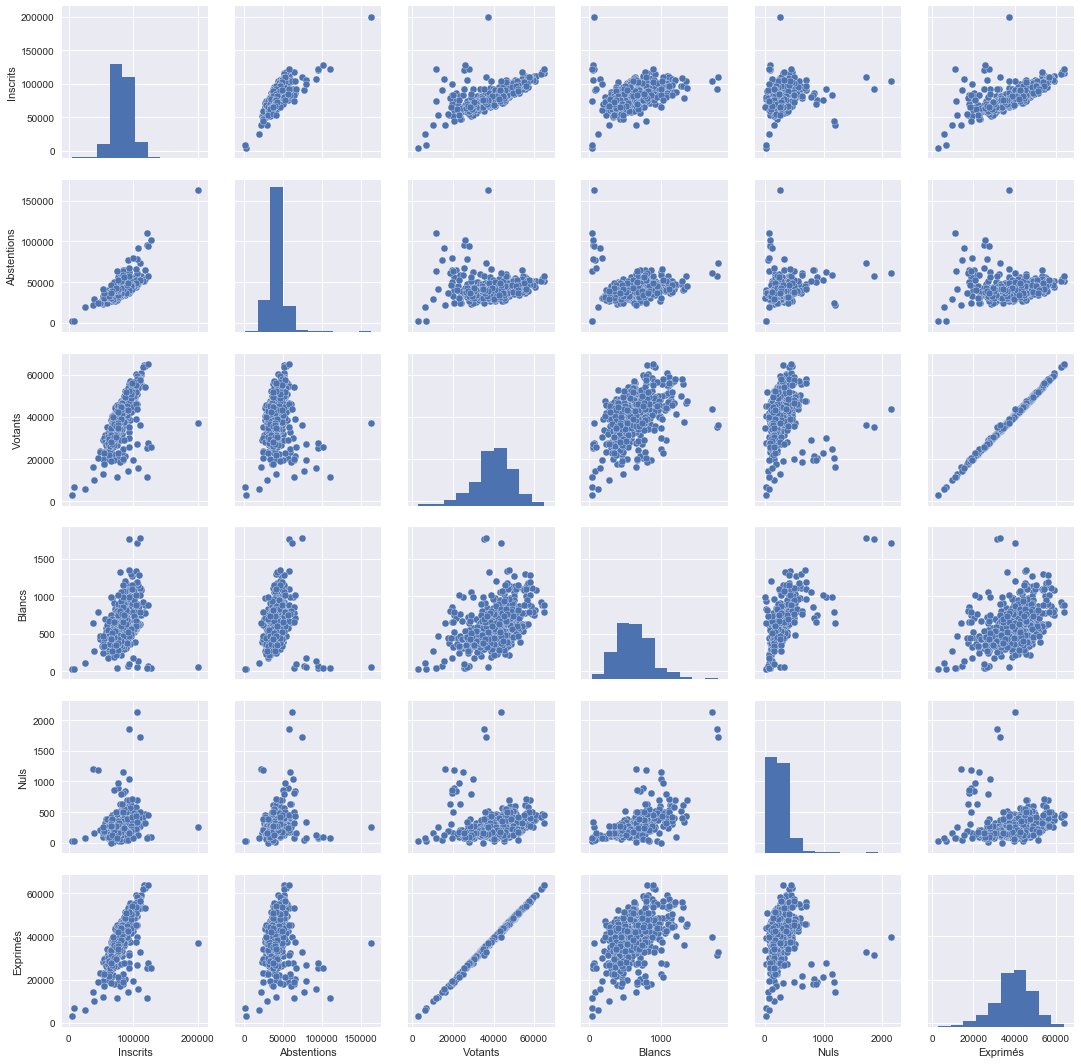

In [24]:
sns.pairplot(all_votes.transpose())

Ce qui ressort de ces diagrammes, c'est qu'il y semble toujours y avoir une relation de proportionnalité entre fondamentalement les inscrits et toutes les autres variables. Plus il y a d'inscrits, plus il y a de votants, de blancs, d'abstentions... etc.

# Par candidat 

Passons maintenant à l'exploitation des autres données que nous avons pu trouver : la répartition par candidat. 

In [25]:
all_candidates_data = []
for url in circo_links:
    circo_name, candidates, votes = extract_circo_data(url)
    candidates.columns = ['Nuances', 'Voix', '% Inscrits', '% Exprimés', 'Ballotage']
    for col in ['Voix', '% Inscrits', '% Exprimés']:
        candidates[col] = pd.to_numeric(candidates[col])
    candidates['Circonscription'] = circo_name
    all_candidates_data.append(candidates)

In [26]:
all_candidates = pd.concat(all_candidates_data)

Les règles qui gouvernent le scrutin sont les suivantes ([source](https://www.service-public.fr/particuliers/vosdroits/F1943)): 

> Pour être élu au 1er tour, un candidat doit recueillir :

> - plus de 50 % des suffrages exprimés,

> - et un nombre de voix au moins égal à 25 % des électeurs inscrits.

> Si aucun candidat n'est élu dès le premier tour, il est procédé à un 2nd tour une semaine plus tard.

> Au 2nd tour, les 2 candidats arrivés en tête peuvent se maintenir.

> Les candidats suivants peuvent se maintenir seulement s'ils ont obtenu un nombre de suffrages au moins égal à 12,5 % des électeurs inscrits.

> Le candidat qui obtient le plus grand nombre de suffrages au 2nd tour est élu.

Au premier tour, les candidats élus d'office étaient les suivants :

In [27]:
all_candidates[all_candidates.Ballotage == 'Oui']

,Nuances,Voix,% Inscrits,% Exprimés,Ballotage,Circonscription
M. Paul MOLAC,REM,30166,28.70,54.00,Oui,Morbihan (56) - 4ème
M. Sylvain MAILLARD,REM,24037,29.76,50.80,Oui,Paris (75) - 1ère
M. Stéphane DEMILLY,UDI,21505,26.40,53.85,Oui,Somme (80) - 5ème
M. Napole POLUTELE,DVG,3436,40.52,50.24,Oui,Wallis et Futuna (986) - 1ère


On peut aggréger les données par nombre de voix :

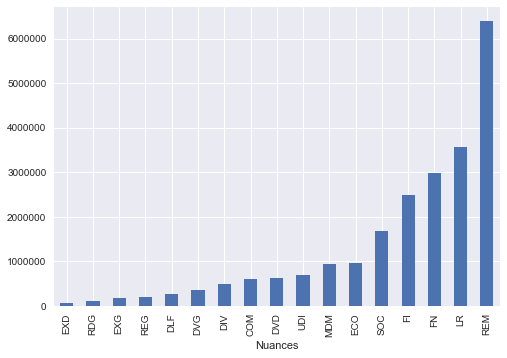

In [28]:
all_candidates.groupby('Nuances').sum()['Voix'].sort_values().plot.bar()

On constate que le grand gagnant de cette élection est la République en Marche. Derrière, on trouve les Républicains, le FN, la France Insoumise et le PS.

On peut, avec les données de ballotage, déterminer le nombre maximum de députés possibles selon la nuance politique.

In [29]:
all_candidates.Ballotage.value_counts()

Non           6726
Ballotage*    1147
Oui              4
Name: Ballotage, dtype: int64

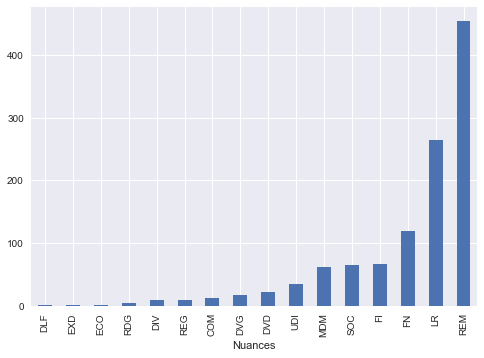

In [30]:
all_candidates[all_candidates.Ballotage == 'Ballotage*'].groupby('Nuances').count()['Voix'].sort_values().plot.bar()

On retrouve la tendance précédente en nombre de voix, mais avec un effet lié au mode de scrutin. 

On peut s'en rendre compte en traçant une droite proportionnelle au nombre de votants et de pente le nombre de députés total (577) divisé par le nombre de votants total.

In [31]:
max_mps = all_candidates[all_candidates.Ballotage == 'Ballotage*'].groupby('Nuances').count()['Voix']
by_voice = all_candidates.groupby('Nuances').sum()['Voix']

In [32]:
mp_voice = pd.DataFrame([max_mps, by_voice]).transpose()
mp_voice.columns = ['Députés max.', 'Voix']
mp_voice = mp_voice.fillna(value=0)

(-10, 500)

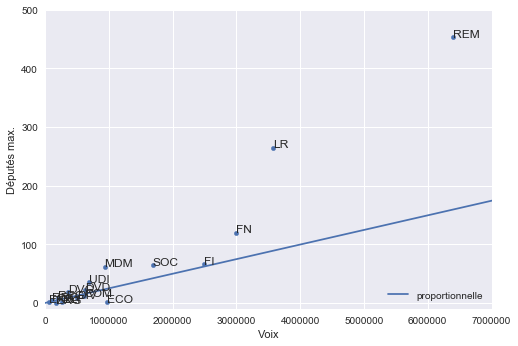

In [33]:
mp_voice.plot.scatter(x='Voix', y='Députés max.')
for label, data in mp_voice.iterrows():
    plt.annotate(xy=(data['Voix'], data['Députés max.']), s=label)
plt.plot([0, all_votes.transpose().sum()['Votants']], [0, 577], label='proportionnelle')
plt.legend(loc='lower right')
plt.xlim(0, 7e6)
plt.ylim(-10, 500)

On remarque que la pente "proportionnelle" est parfois bien loin du nombre de siège maximum que l'on peut attendre à ce stade là. 

La République en marche peut par exemple finir avec près de 500 députés alors que la proportionnalité au nombre de votants impliquerait seulement 200 députés. 

A l'inverse, la France Insoumise peut devenir au mieux représentative de son vote proportionnel et cela seulement si elle gagne dans toutes les circonscriptions où elle se trouve en ballotage.


Mais ces points sont très limités ! Pour aller plus loin, nous pouvons proposer un modèle statistique assez simple.

# Modèle probabiliste pour les résultats du second tour des législatives

Le graphe précédent est intéressant, mais malheureusement, il ne permet pas de juger de manière de ce qui peut se passer au second tour, dans la mesure où nous ne dessinons que le nombre maximum de députés par nuance politique, mais pas le nombre minimum. Pour faire cela, nous pouvons proposer un modèle probabiliste très simple : pour chaque circonscription, nous tirons au hasard l'un des députés en ballotage, avec le pourcentage calculé à partir de ses votes du premier tour (on suppose que les reports se font de manière équilibré vis à vis des candidats en ballotage au premier tour).

Prenons un exemple. Dans la première circonscription de l'Ain, nous avons les candidats suivants pour le ballotage.

In [34]:
all_candidates[(all_candidates.Circonscription == 'Ain (01) - 1ère') & (all_candidates.Ballotage == 'Ballotage*')]

,Nuances,Voix,% Inscrits,% Exprimés,Ballotage,Circonscription
M. Laurent MALLET,MDM,13534,16.37,33.89,Ballotage*,Ain (01) - 1ère
M. Xavier BRETON,LR,10693,12.93,26.78,Ballotage*,Ain (01) - 1ère


Le candidat Modem a reçu 13534 voix, tandis que le candidat LR a reçu 10693 voix. On voit que les candidats sont à peu près à égalité. On peut donc faire des tirages dont la probabilité est proportionnelle à ce nombre de voix.

Le tirage se fait donc sur la base de ce nombre de voix normalisé. On peut construire une variable aléatoire avec [Scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.rv_discrete.html) sur ce principe.

In [38]:
voices = [13534, 10693]

In [39]:
xk = np.arange(len(voices))
pk = np.array(voices) / np.sum(voices)
custm = stats.rv_discrete(name='custm', values=(xk, pk))

On peut avec cet objet, faire des tirages. Si on fait autant de tirages que de voix exprimées pour ces deux candidats initialement, on peut vérifier que le tirage fonctionne bien.

In [40]:
pd.Series(custm.rvs(size=(13534 + 10693))).value_counts()

0    13581
1    10646
dtype: int64

Ceci nous permet d'écrire une fonction qui donne une nuance vainqueur par circonscription.

In [41]:
def predict_winner(circo_name, size=1):
    "Simulates who will win a given circonscription."
    df_circo = all_candidates[all_candidates.Circonscription == circo_name]
    if 'Oui' in df_circo['Ballotage'].any():
        return np.array([v for v in df_circo.Nuances[df_circo.Ballotage == 'Oui'].values] * size)
    else:
        mask = df_circo.Ballotage == 'Ballotage*'
        voices = df_circo.Voix[mask].values
        nuances = df_circo.Nuances[mask].values
        xk = np.arange(voices.size)
        pk = np.array(voices) / np.sum(voices)
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        return nuances[custm.rvs(size=size)]

On peut vérifier que la simulation fonctionne :

In [42]:
predict_winner(circo_name, size=100)

array(['LR', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM', 'REM', 'REM', 'LR',
       'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'LR', 'REM', 'LR', 'REM',
       'LR', 'REM', 'REM', 'LR', 'LR', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM',
       'REM', 'REM', 'REM', 'LR', 'LR', 'LR', 'REM', 'REM', 'LR', 'LR',
       'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM', 'REM', 'LR', 'REM',
       'REM', 'REM', 'LR', 'REM', 'LR', 'LR', 'REM', 'LR', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM', 'REM', 'REM', 'LR',
       'REM', 'REM', 'LR', 'REM', 'REM', 'REM', 'REM', 'REM', 'LR', 'REM',
       'REM', 'REM', 'REM', 'LR', 'LR', 'LR', 'REM', 'REM', 'REM', 'LR'], dtype=object)

Ainsi que dans une circonscription où le premier tour a déjà déterminé le gagnant :

In [43]:
predict_winner('Morbihan (56) - 4ème', size=100)

array(['REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM',
       'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM'], 
      dtype='<U3')

On peut maintenant, à partir de la liste des circonscriptions, faire des simulations.

In [44]:
simulation_data = [predict_winner(circo_name, 10000) for circo_name in all_candidates.Circonscription.unique()]

In [45]:
parliaments = pd.DataFrame(simulation_data, index=all_candidates.Circonscription.unique()).transpose()

In [46]:
parliaments.head()

,Ain (01) - 1ère,Ain (01) - 2ème,Ain (01) - 3ème,Ain (01) - 4ème,Ain (01) - 5ème,Aisne (02) - 1ère,Aisne (02) - 2ème,Aisne (02) - 3ème,Aisne (02) - 4ème,Aisne (02) - 5ème,...,Français établis hors de France (99) - 2ème,Français établis hors de France (99) - 3ème,Français établis hors de France (99) - 4ème,Français établis hors de France (99) - 5ème,Français établis hors de France (99) - 6ème,Français établis hors de France (99) - 7ème,Français établis hors de France (99) - 8ème,Français établis hors de France (99) - 9ème,Français établis hors de France (99) - 10ème,Français établis hors de France (99) - 11ème
0,LR,LR,REM,REM,REM,FN,FN,SOC,REM,REM,...,REM,SOC,REM,FI,REM,MDM,REM,DIV,LR,LR
1,MDM,MDM,REM,FN,LR,REM,LR,FN,REM,FN,...,ECO,REM,REM,FI,REM,MDM,REM,DVD,LR,REM
2,MDM,LR,REM,REM,REM,REM,LR,FN,REM,REM,...,REM,REM,REM,REM,LR,MDM,REM,DVD,REM,REM
3,LR,MDM,REM,REM,LR,REM,FN,SOC,FN,REM,...,REM,REM,REM,REM,REM,MDM,REM,DVD,REM,REM
4,LR,MDM,REM,REM,REM,REM,LR,FN,FN,FN,...,REM,REM,REM,REM,REM,MDM,REM,DIV,REM,REM


On va aggréger ces simulations en comptant le nombre de députés par partie.

In [47]:
parliament_counts = pd.concat([series.value_counts() for ind, series in parliaments.iterrows()], axis=1).fillna(value=0)

In [48]:
parliament_counts.transpose().head()

,COM,DIV,DLF,DVD,DVG,ECO,EXD,FI,FN,LR,MDM,RDG,REG,REM,SOC,UDI
0,3.0,2.0,0.0,12.0,9.0,0.0,0.0,20.0,47.0,115.0,34.0,3.0,2.0,286.0,32.0,12.0
1,4.0,5.0,0.0,7.0,10.0,2.0,1.0,21.0,53.0,105.0,46.0,3.0,3.0,272.0,33.0,12.0
2,6.0,3.0,0.0,10.0,11.0,1.0,0.0,28.0,51.0,99.0,40.0,1.0,6.0,287.0,21.0,13.0
3,5.0,0.0,0.0,9.0,11.0,1.0,1.0,22.0,45.0,102.0,35.0,4.0,3.0,286.0,32.0,21.0
4,3.0,3.0,0.0,8.0,9.0,0.0,1.0,19.0,55.0,108.0,37.0,3.0,3.0,290.0,23.0,15.0


On peut trier ces données par nombre de députés et faire la moyenne des simulations que nous avons faites.

In [49]:
parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['min', '25%', '50%', '75%', 'max']].transpose()

,EXD,DLF,ECO,RDG,DIV,REG,COM,DVD,DVG,UDI,FI,SOC,MDM,FN,LR,REM
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,6.0,8.0,13.0,23.0,29.0,82.0,237.0
25%,0.0,0.0,1.0,1.0,3.0,3.0,4.0,8.0,9.0,14.0,20.0,24.0,35.0,47.0,103.0,272.0
50%,0.0,0.0,1.0,2.0,4.0,4.0,6.0,9.0,10.0,16.0,22.0,26.0,38.0,50.0,108.0,279.0
75%,1.0,1.0,1.0,3.0,5.0,5.0,7.0,11.0,11.0,18.0,25.0,29.0,40.0,54.0,114.0,286.0
max,1.0,1.0,2.0,5.0,9.0,9.0,12.0,17.0,16.0,26.0,38.0,40.0,53.0,71.0,140.0,315.0


Ces résultats ne tiennent pas compte du fait que des alliances éventuelles vont en fait changer la manière dont se feront les reports de vote. Typiquement, on peut envisager des stratégies comme le barrage au FN, qui va donc tendre à accentuer le report des votes vers les autres candidats et les alliances entre France Insoumise et le Parti Communiste, qui peut renforcer la représentation de ces partis.

Sans rentrer dans ces subtilités, on peut s'en tenir aux estimations suivantes, représentées avec des barres d'erreur.

In [50]:
sorted_columns = parliament_counts.transpose().describe().transpose().sort_values(by='mean').index.values

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


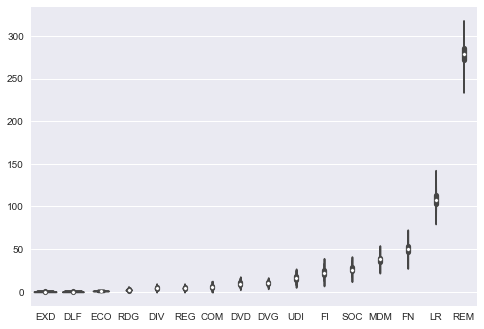

In [51]:
sns.violinplot(parliament_counts.transpose()[sorted_columns])

On peut donc reprendre le graphique précédent avec les score attendus en proportion des voix reçues au premier tour et comparer ceci au score attendu d'après les simulations. 

In [53]:
proportion_seats = all_candidates.groupby('Nuances').sum()['Voix'] / all_votes.transpose().sum()['Votants'] * 577

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


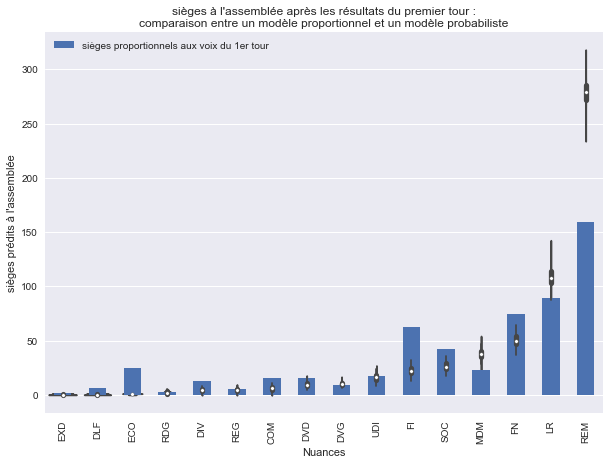

In [57]:
fig, ax = plt.subplots(figsize=(10, 7))
proportion_seats[sorted_columns].to_frame(name='sièges proportionnels aux voix du 1er tour').plot.bar(ax=ax)
sns.violinplot(parliament_counts.transpose()[sorted_columns], label='modèle probabiliste', ax=ax)
plt.ylabel("sièges prédits à l'assemblée")
plt.legend(loc='upper left')
plt.title("sièges à l'assemblée après les résultats du premier tour :\ncomparaison entre un modèle proportionnel et un modèle probabiliste");

Le graphique ci-dessus permet de conclure quant à la question initiale avec des données quantitatives : il semble que les conditions du scrutin favorisent grandement la République en Marche dans la mesure où en proportion des voix exprimées, le nombre de députés REM devrait être seulement la moitié de ce que le modèle probabiliste propose. De même, les autres gagnants sont LR et le Modem, alors que les perdants sont le FN, les socialistes, la France Insoumise, et les écologistes dont le nombre de siège tend vers 0 alors qu'une fraction importantes des votants s'est déclaré en sa faveur.  

# Conclusions 

Dans ce billet, nous sommes partis des pages officielles du ministère de l'intérieur. Nous avons extrait les données pour les 577 circonscriptions, les avons représentés et étudiés l'effet des règles du scrutin sur la répartition des sièges au travers d'un modèle probabiliste. 

Ceci nous a permis de mettre en évidence quels partis peuvent être considérés comme les vainqueurs ou les perdants de ce premier tour des législatives. Le modèle probabiliste permet de prédire que le raz-de-marée de la République en Marche devrait lui permettre d'atteindre une majorité absolue, à quelques sièges près, en décalage avec la proportion de votants en faveur du parti, nettement inférieur. Ce déséquilibre est dû au mode de scrutin, qui favorise en ballotage les partis avec des scores importants au premier tour. Ces résultats sont assez étonnants, notamment du fait que plus de la moitié des inscrit n'a pas voté lors de ces élections.